In [ ]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

True

In [ ]:
llm = ChatOpenAI(model="gpt-4o")

In [ ]:
# Schema for structured output
from pydantic import BaseModel, Field
from langchain_community.tools import TavilySearchResults


class SearchQuries(BaseModel):
    search_query: list = Field(
        None, description="List of Queries that are optimized for web search."
    )
    justification: list = Field(
        None, description="Why each query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuries)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")


# Define a tool
tavily_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([tavily_tool])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke(
    "nvidia 주가 하락의 원인이 된 대상 이름이 뭐야?그리고 그 대상에 대한 정보 알려줘"
)

# Get the tool call
msg.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'NVIDIA stock drop cause company name'},
  'id': 'call_0M7m41CWPAFdhqea56TorW7T',
  'type': 'tool_call'}]

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


class SearchQury(BaseModel):
    search_query: str = Field(
        None, description="Query that is optimized for web search."
    )
    justification: str = Field(
        None, description="Why query is relevant to the user's request."
    )


class Reference(BaseModel):
    """Model for a reference"""

    title: str = Field(description="The title of the reference.")
    url: str = Field(description="The url of the reference.")


# Graph state
class State(TypedDict):
    search_queries: list[SearchQury]
    combined_output: str



In [ ]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class SearchQuery(BaseModel):
    query: str = Field(None, description="Query that is optimized for web search.")
    justification: str = Field(
        None, description="Why query is relevant to the user's request."
    )


class SearchQueries(BaseModel):
    queries: List[SearchQuery] = Field(
        description="List of search queries and their justifications.",
    )


class Reference(BaseModel):
    """Model for a reference"""

    title: str = Field(description="The title of the reference.")
    url: str = Field(description="The url of the reference.")
    content: str = Field(description="The content of the reference.")
    summary: str = Field(description="The summary of the reference.")


class State(TypedDict):
    question: str  # The difficult question to answer
    queries: List[SearchQuery]  # List of generated search queries
    references: Annotated[
        list, operator.add
    ]  # Aggregated search results from tavily tool
    final_answer: str  # Final synthesized answer


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(SearchQueries)

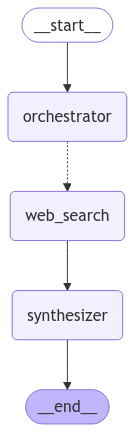

In [ ]:
from langgraph.constants import Send, START, END
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage
from typing_extensions import TypedDict
from langchain_core.runnables import RunnableConfig


class WorkerState(TypedDict):
    query: SearchQuery  # The search query for this worker
    completed_results: Annotated[
        list, operator.add
    ]  # Shared list for aggregating results


# Node: Orchestrator
def orchestrator(state: State) -> dict:
    """
    Generate a set of search queries based on the difficult question

    - Use the planner LLM to generate queries
    - Return the generated queries list under key 'queries'
    """
    generated = planner.invoke(
        [
            SystemMessage(
                content="Generate a list of search queries that are required to answer the difficult question"
            ),
            HumanMessage(content=f"Here is the question: {state['question']}"),
        ]
    )
    # Assume that the planner returns an object with an attribute 'queries' that is a list of Query
    return {"queries": generated.queries}


# Node: Worker using the tavily tool
def web_search(state: WorkerState) -> dict:
    """
    Execute a search for the provided query using the tavily tool

    - Extract the query text from the state
    - Invoke the tavily search tool with the query
    - Return the search result as part of completed_results
    """
    query_text = state["query"].query  # Use attribute access instead of subscripting
    search_result = tavily_tool.invoke(query_text)
    references = List(Reference())
    for search in search_result:
        references.append(
            Reference(
                title=search.title,
                url=search.url,
                content=search.content,
            )
        )
    return {"references": references}


async def summarization_node(state: WorkerState, config: RunnableConfig):
    """
    The summarization node is responsible for extracting and summarizing information from a web search.
    """

    system_message = f"""
This is the result of the search:

Please summarize ONLY the result of the search and include all relevant information from the search and reference links.
DO NOT INCLUDE ANY EXTRA INFORMATION. ALL OF THE INFORMATION YOU ARE LOOKING FOR IS IN THE SEARCH RESULTS.

DO NOT answer the user's query yet. Just summarize the search results.

Use markdown formatting and put the references inline and the links at the end.
Like this:
This is a sentence with a reference to a source [source 1][1] and another reference [source 2][2].
[1]: http://example.com/source1 "Title of Source 1"
[2]: http://example.com/source2 "Title of Source 2"
"""


# Node: Synthesizer
def synthesizer(state: State) -> dict:
    """
    Synthesize the final answer from aggregated search results

    - Combine the search results into a single context string
    - Use the llm to summarize the search results and answer the question
    - Return the final answer
    """
    summary = llm.invoke(
        [
            SystemMessage(
                content="Summarize the following search results to answer the difficult question"
            ),
            HumanMessage(
                content=f"Search results:\n{state['completed_results']}\n\nQuestion: {state['question']}"
            ),
        ]
    )
    return {"final_answer": summary.content}


# Conditional edge: Assign a web_search worker for each generated query
def assign_workers(state: State) -> List[Send]:
    """
    Assign a web_search worker for each query in the generated plan

    - Iterate over each query in state['queries']
    - For each query, send a task to the web_search worker
    """
    return [Send("web_search", {"query": q}) for q in state["queries"]]


# Build the workflow
workflow_builder = StateGraph(State)

# Add nodes to the workflow
workflow_builder.add_node("orchestrator", orchestrator)
workflow_builder.add_node("web_search", web_search)
workflow_builder.add_node("synthesizer", synthesizer)

# Connect nodes with edges
workflow_builder.add_edge(START, "orchestrator")
workflow_builder.add_conditional_edges("orchestrator", assign_workers, ["web_search"])
workflow_builder.add_edge("web_search", "synthesizer")
workflow_builder.add_edge("synthesizer", END)

# Compile the workflow
graph = workflow_builder.compile()

# Optionally, display the workflow graph (if running in a Jupyter environment)
from IPython.display import Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
import asyncio
from typing import Any, Dict, List, Callable
from langchain_core.runnables import RunnableConfig
from langgraph.graph.state import CompiledStateGraph


async def astream_graph(
    graph: CompiledStateGraph,
    inputs: Dict[str, Any],
    config: RunnableConfig,
    node_names: List[str] = [],
    callback: Callable[[Dict[str, str]], None] = None,
):
    """
    LangGraph의 실행 결과를 비동기 방식으로 스트리밍하여 출력하는 함수입니다.

    매개변수:
    - graph (CompiledStateGraph): 실행할 컴파일된 LangGraph 객체
    - inputs (dict): 그래프에 전달할 입력값 딕셔너리
    - config (RunnableConfig): 실행 설정
    - node_names (List[str], optional): 출력할 노드 이름 목록 (빈 리스트면 모든 노드 출력)
    - callback (Callable[[Dict[str, str]], None], optional): 각 청크 처리를 위한 콜백 함수 (기본값: None)
      콜백 함수는 {"node": str, "content": str} 형태의 딕셔너리를 인자로 받습니다.

    반환값:
    - None: 함수는 스트리밍 결과를 출력만 하고 반환값은 없습니다.
    """
    prev_node = ""
    async for chunk_msg, metadata in graph.astream(
        inputs, config, stream_mode="messages"
    ):
        curr_node = metadata["langgraph_node"]

        # node_names가 비어있거나 현재 노드가 node_names에 포함된 경우에만 처리
        if not node_names or curr_node in node_names:
            if callback:
                callback({"node": curr_node, "content": chunk_msg.content})
            else:
                # 노드가 변경될 때마다 헤더를 출력
                if curr_node != prev_node:
                    print("\n" + "=" * 60)
                    print(f"🔹 Node: {curr_node} 🔹")
                    print("=" * 60)

                # 쿼리 정보가 있으면 출력
                tool_calls = chunk_msg.additional_kwargs.get("tool_calls", [])
                if tool_calls:
                    # print(f"🔍 Query: ", end="")
                    for tool_call in tool_calls:
                        query = tool_call.get("function", {}).get("arguments", "")
                        if query:

                            print(f"\033[1;33m{query}\033[0m", end="", flush=True)
                else:
                    # 쿼리 정보가 없으면 content 출력
                    content = chunk_msg.content.strip()
                    if content:
                        print(f"\033[1;33m{content}\033[0m", end="", flush=True)

            prev_node = curr_node

In [ ]:
config = {
    "configurable": {
        "thread_id": 1,  # temporary thread ID for testing
    },
}

initial_state: State = {
    "question": "How does quantum computing impact cryptography in a post-quantum world",
    "queries": [],
    "completed_results": [],
    "final_answer": "",
}

In [ ]:
await astream_graph(graph, initial_state, config=config)


🔹 Node: orchestrator 🔹
{"queries":[{"query":"impact of quantum computing on cryptography","justification":"To understand the general effects of quantum computing on cryptographic methods."},{"query":"post-quantum cryptography solutions","justification":"To learn about cryptographic methods that are resistant to quantum attacks."},{"query":"Shor's algorithm impact on RSA encryption","justification":"To understand how specific quantum algorithms threaten RSA encryption."},{"query":"Grover's algorithm effect on symmetric cryptography","justification":"To examine how quantum algorithms could affect symmetric encryption methods."},{"query":"current research in post-quantum cryptography","justification":"To identify the latest developments and proposals in cryptography that can withstand quantum computing."},{"query":"quantum computing threats to cybersecurity","justification":"To explore the broader implications of quantum computing on cybersecurity."},{"query":"timeline for quantum comput

ValidationError: 4 validation errors for Reference
title
  Field required [type=missing, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing
url
  Field required [type=missing, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing
content
  Field required [type=missing, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing
summary
  Field required [type=missing, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing

In [ ]:
from pprint import pprint

# Invoke the workflow with a difficult question
initial_state: State = {
    "question": "How does quantum computing impact cryptography in a post-quantum world",
    "queries": [],
    "completed_results": [],
    "final_answer": "",
}

final_state = graph.stream(initial_state, stream_mode=["updates"])
for state in final_state:
    pprint(state)

('updates',
 {'orchestrator': {'queries': [SearchQuery(query='impact of quantum computing on cryptography', justification='To understand the general influence of quantum computing on existing cryptographic methods.'),
                               SearchQuery(query='post-quantum cryptography', justification='To explore cryptographic methods that are designed to be secure against quantum computing attacks.'),
                               SearchQuery(query='quantum computing breaking RSA encryption', justification='To investigate how quantum computers could potentially break widely used cryptographic algorithms like RSA.'),
                               SearchQuery(query="Shor's algorithm and cryptography", justification="To explore how Shor's algorithm can be used by quantum computers to factor large numbers, impacting cryptographic security."),
                               SearchQuery(query='quantum key distribution', justification='To look into how quantum computing presents new

ValidationError: 4 validation errors for Reference
title
  Field required [type=missing, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing
url
  Field required [type=missing, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing
content
  Field required [type=missing, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing
summary
  Field required [type=missing, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/missing

In [ ]:
# Render the final answer using Markdown
from IPython.display import Markdown

final_state

In [ ]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])